In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


if 'thesis.Aircraft' in sys.modules: del sys.modules['thesis.Aircraft']
from thesis.Aircraft import Aircraft

if 'thesis.Flight' in sys.modules: del sys.modules['thesis.Flight']
from thesis.Flight import Flight

# Just some figuring out how heavy we are
# https://www.doubleradius.com/site/stores/baicells/baicells-nova-233-gen-2-enodeb-outdoor-base-station-datasheet.pdf
# Unsure how massive antenna are, guessing 1 kg
# Potentially unreliable sources say that the Starlink terminal is about 12 Ibs (https://www.reddit.com/r/Starlink/comments/jqck07/how_much_does_dishy_weigh/)
m_payload = 4.4 + 1 + 6  # kg
# Starlink power figure https://arstechnica.com/information-technology/2020/11/spacex-starlink-beta-tester-takes-user-terminal-into-forest-gets-120mbps/
# This figure may be overstated as it is for that users "whole system" (router, other equipment included?)
P_payload = 45 + 120       # W

wingSpan = 10 # m
wingChord = 0.5 # m
wingArea = wingSpan * wingChord # m^2
solarFill = 0.85 # % of wing surface with solar PV
solarArea = wingArea * solarFill # Solar panel area m^2

# Guesses
P_solar_cap = 1000 # Maximum solar power in (W)
P_prop = 600       # Maximum propellor power (W)

# Mostly taken from Oettershagen2017Design
m_struct = 6 # Guessing
m_prop = 0.0011 * P_prop
m_solar = 0.59 * solarArea
m_mppt = 0.422 * 0.422e-3 * P_solar_cap
m_av = 1.22
bat_Wh_cap = 3000
# From Oettershagen
#m_bat = bat_Wh_cap / 251
# From hypothetical Licerion/Sionpower Lithium-metal cells
m_bat = bat_Wh_cap / 650

mass = m_struct + m_prop + m_solar + m_mppt + m_av + m_payload + m_bat
print('Mass is %.2f kg' % mass)

craft = Aircraft(mass = mass, wingSpan = wingSpan, e0 = 0.92, chord = wingChord)

Mass is 26.58 kg


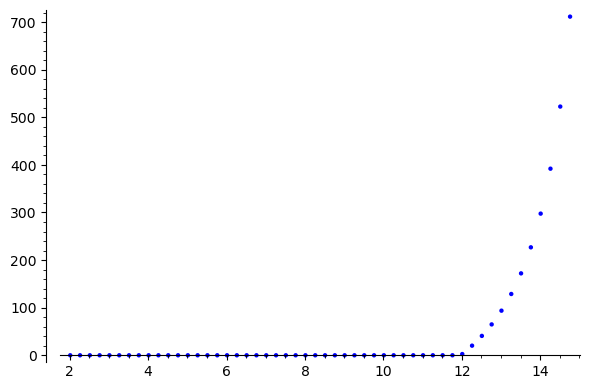

In [94]:
list = []
for a in np.arange(2.01, 15, 0.25):
    list.append((a, craft.straightPower(-5 * pi / 180, a, 0).n()))
    
list_plot(list)

In [55]:
def displayTrajectoryInfo(trajectory, render = True, threed = False):
    flight = Flight(craft, trajectory, [5 for p in trajectory.pieces])
    T0 = pd.to_datetime('2020-07-01T00')
    dt = pd.to_timedelta(int(flight.cycleTime), 'S')
    times = pd.date_range(start=T0, end=T0 + dt, freq='30S', tz='America/Detroit')

    print('%d Second cycles, for %d cycles with %d left over' % (
        flight.cycleTime,
        (24 * 3600) / flight.cycleTime,
        (24 * 3600) % flight.cycleTime
    ))
    poses = flight.toPoses(times.to_series())
    if render:
        if threed:
    #         show(sum([
    #             line(((
    #                 poses['x'][poses.index[i-1]],
    #                 poses['y'][poses.index[i-1]],
    #                 poses['z'][poses.index[i-1]]
    #             ), (
    #                 poses['x'][poses.index[i]],
    #                 poses['y'][poses.index[i]],
    #                 poses['z'][poses.index[i]]
    #             )), color=hue(i/len(poses.index)), linewidth=400)
    #             for i in range(len(poses.index))
    #         ]))
            show(flight._trajectory.render())
        else:
            points = [
                point((
                    poses['x'][poses.index[i]],
                    poses['y'][poses.index[i]],
                    #poses['z'][poses.index[i]]
                ), color=hue(i / len(poses.index)), size=100)
                for i in range(len(poses.index))
            ]
            show(sum(points), aspect_ratio=1)
    
def displayTrajectoryPower(trajectory):
    flight = Flight(craft, trajectory, [5 for p in trajectory.pieces])
    times = pd.date_range(start='2020-07-01T08', end='2020-07-03T08', freq='30S', tz='America/Detroit')
    poses = flight.toPoses(times.to_series())
    
    solar = craft.calcSolarPower(poses, 43, -84)
    battery = craft.calcBatteryCharge(poses, solar, bat_Wh_cap, constant_draw = P_payload)

    fix, ax1 = plt.subplots(figsize=(18,10))
    ax1.set_xlabel('local time')
    ax1.set_ylabel('Power [W]')
    ax1.set_ylim(bottom = 0, top = solar.max() * 1.1)

    solar.plot(color='tab:orange')
    poses.power.plot(color='tab:blue')
    (poses.power + P_payload).plot(color='tab:cyan')

    # Gravitational potential energy in Wh
    base_height = poses['z'].min()
    E_g = (poses.z - base_height) * 9.8 * mass / 3600

    ax2 = ax1.twinx()
    ax2.set_ylabel('Energy [Wh]', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim(bottom = 0, top = (battery + E_g).max() * 1.1)
    battery.plot(color='tab:red')
    if poses['z'].max() - base_height > 10:
        # Show potential energy as well, if we have a reasonable amount
        (battery + E_g).plot(color='tab:cyan')

    print('mSoc = %.2f%%' % (battery.min() / bat_Wh_cap * 100))

550 Second cycles, for 157 cycles with 30 left over
2020-07-01 00:09:00-04:00


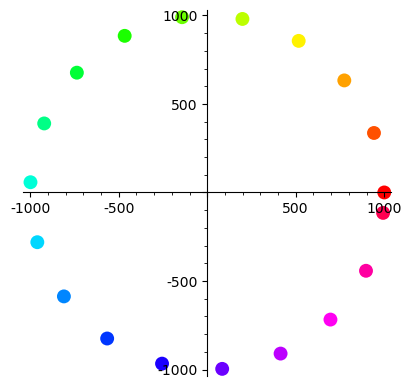

2020-07-03 08:00:00-04:00
mSoc = 50.00%


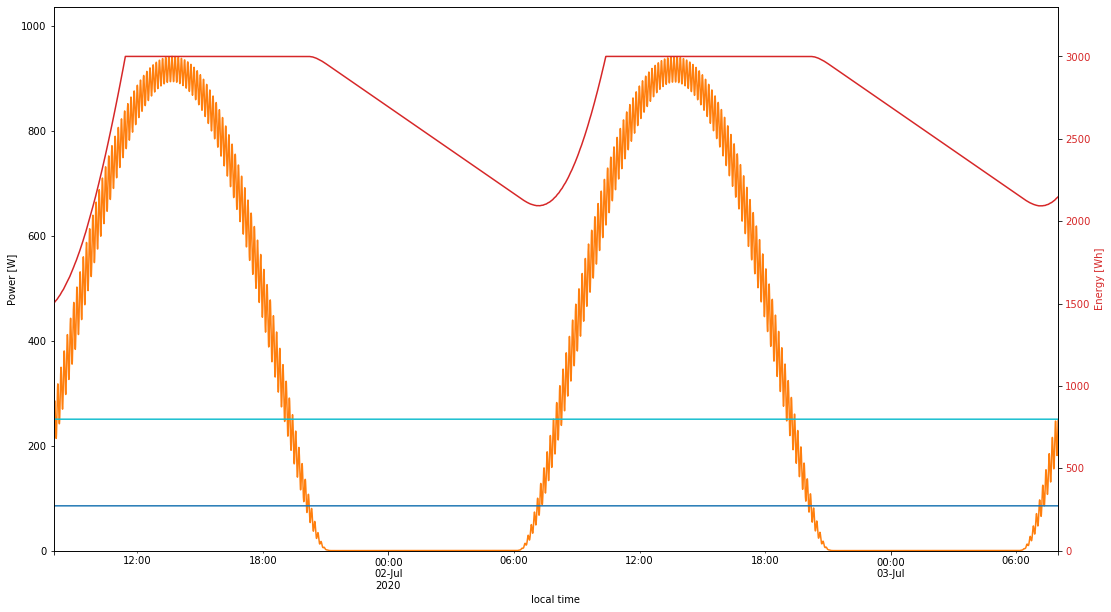

In [56]:
if 'thesis.Trajectory' in sys.modules: del sys.modules['thesis.Trajectory']
from thesis.Trajectory import CircleTrajectory
trajectory = CircleTrajectory((0, 0, 1000), 1000)

displayTrajectoryInfo(trajectory)
displayTrajectoryPower(trajectory)

999 Second cycles, for 86 cycles with 425 left over
2020-07-01 00:16:30-04:00


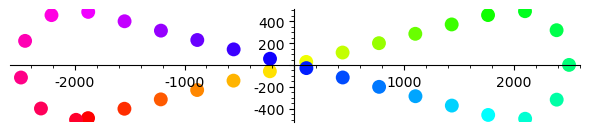

2020-07-03 08:00:00-04:00
mSoc = 4.16%


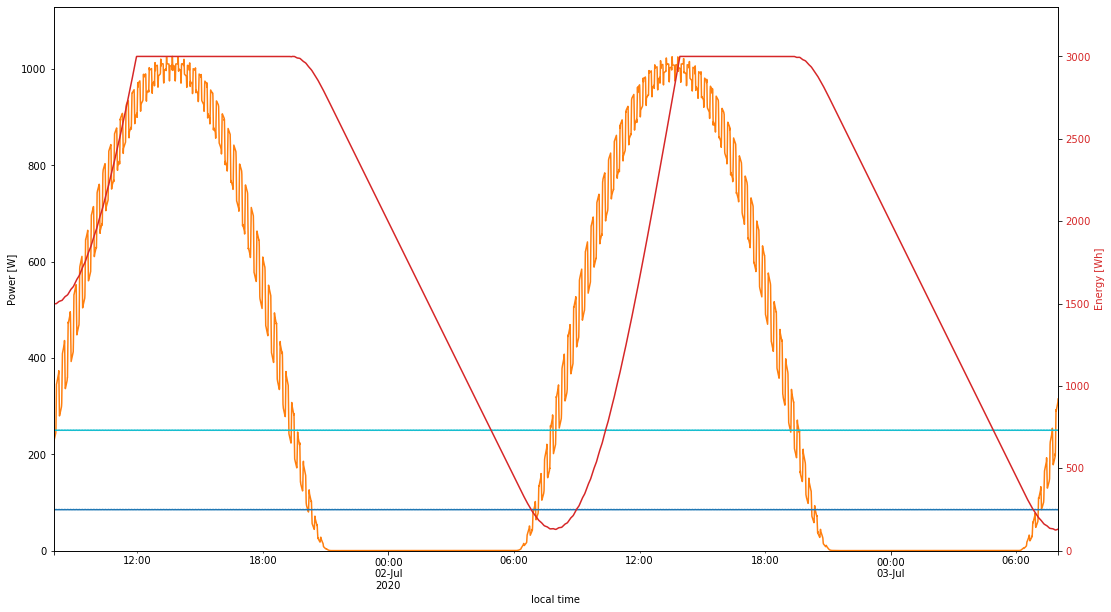

In [9]:
if 'thesis.Trajectory' in sys.modules: del sys.modules['thesis.Trajectory']
from thesis.Trajectory import BowtieTrajectory
trajectory = BowtieTrajectory(0, 0, 2000, lobeRadius = 500, lobeCenterDistance = 2004)

displayTrajectoryInfo(trajectory)
displayTrajectoryPower(trajectory)

86400 Second cycles, for 0 cycles with 0 left over
2020-07-02 00:00:00-04:00


Graphics3d Object

2020-07-03 08:00:00-04:00
mSoc = 14.89%


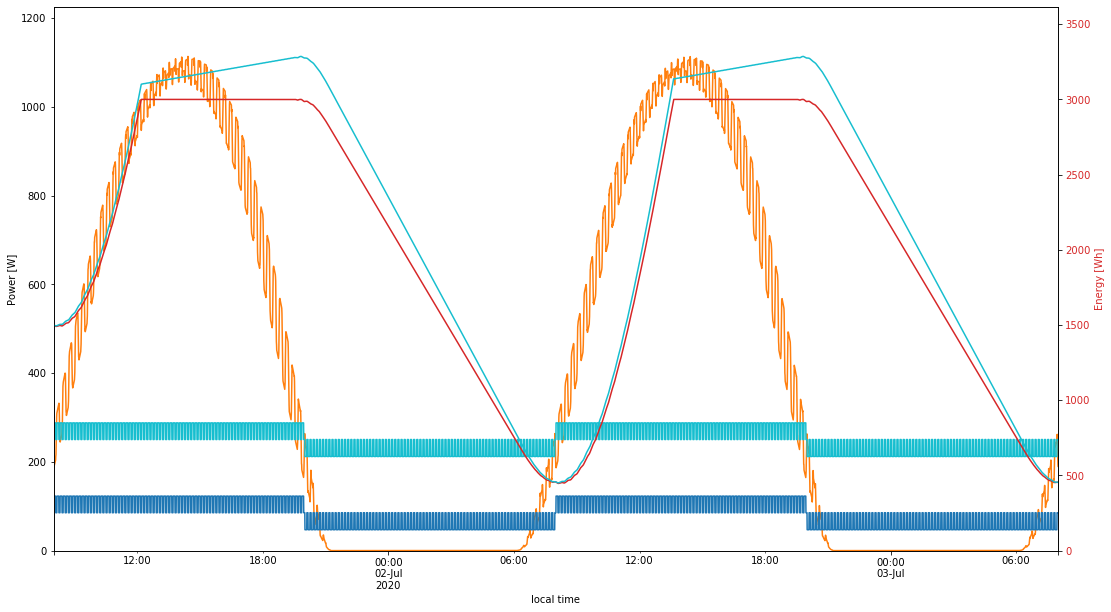

In [28]:
if 'thesis.Trajectory' in sys.modules: del sys.modules['thesis.Trajectory']
from thesis.Trajectory import SimpleLadderTrajectory
base_height = 1000

trajectory = SimpleLadderTrajectory(
    (0, 0, base_height),
    lobeRadius = 600.08,
    lobeCenterDistance = 2050,
    stepHeight=50,
    nSteps=40
)

displayTrajectoryInfo(trajectory, threed=True)
displayTrajectoryPower(trajectory)